<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/cellAtlas_Generation_KNN_NCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Mon Aug 17 20:20:34 UTC 2020


In [1]:
#Read in filtered starved data
!wget --quiet https://caltech.box.com/shared/static/13jsqkczkskrf6cau9p4evhnmqyp7jn3
#Original clustering 
!wget --quiet https://caltech.box.com/shared/static/ts2i8pid7uky28kke4duyl8jwugx8z4h

#Read in filtered stimulation data 
!wget --quiet https://caltech.box.com/shared/static/hd36giuxz3zd933fh4bca3iqnykncro8

In [2]:
#Unfiltered, raw starvation counts
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

#Unfiltered, raw stimulation counts
!wget --quiet https://caltech.box.com/shared/static/cy5n9b6rdyk7v4uhvgvpkgotmchlts45

In [3]:
#Save merged datasets
!wget --quiet https://caltech.box.com/shared/static/jf24fsdq7ojrbwxwf3mc7pqecnrjhpem

#Data only contained Fed and SW control
!wget --quiet https://caltech.box.com/shared/static/tq6f5fqcmhw9h6kphzk8bvt5qx8xew90

In [4]:
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

     |████████████████████████████████| 122kB 7.9MB/s 
     |████████████████████████████████| 7.7MB 4.9MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 2.4MB 5.3MB/s 
     |████████████████████████████████| 3.2MB 46.4MB/s 


###**Import packages**

In [5]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

###**Map Starvation Labels and to Stimulation Cells**

Read in data

In [44]:
#bus_fs_combo data (filtered bus data), bus_combo_noZero (filtered stim data)

#bus_fs_combo
bus_fs_combo = anndata.read("13jsqkczkskrf6cau9p4evhnmqyp7jn3")

#orig = anndata.read("ts2i8pid7uky28kke4duyl8jwugx8z4h")

print(bus_fs_combo)
#print(orig)
#bus_combo_noZero
bus_combo_noZero = anndata.read("hd36giuxz3zd933fh4bca3iqnykncro8")
print(bus_combo_noZero)

#Previously saved overlap, merged data
overlap_combo = anndata.read("jf24fsdq7ojrbwxwf3mc7pqecnrjhpem")
overlap_combo

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 19054 × 10260
    obs: 'batch', 'n_counts', 'n_countslog', 'leiden', 'condition', 'orgID'
    var: 'n_counts'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


AnnData object with n_obs × n_vars = 32727 × 6756
    obs: 'batch', 'condition', 'fed', 'fed_neighbor_score', 'leiden', 'louvain', 'n_counts', 'n_countslog', 'orgID', 'starved', 'knn_clus', 'cell_origin'
    var: 'n_counts-0', 'n_counts-1'
    uns: 'cell_origin_colors', 'draw_graph', 'knn_clus_colors', 'knn_clus_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_draw_graph_fa', 'X_nca', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Predict labels for stimulation data


In [7]:
#Make X_pca with merged, use top 30 PC's
def getPredLabels(overlap_fs,overlap_combo, n_PC):
    
    numFS = len(overlap_fs.obs_names)
    X_train = overlap_combo.obsm['X_pca'][0:numFS,0:n_PC]

    #X_pca at stim rows = X_test
    X_test = overlap_combo.obsm['X_pca'][numFS:,0:n_PC]

    #y_train is f/s louvain labels
    y_train = overlap_fs.obs['cellRanger_louvain']

    #Fit and predict
    classifier = KNeighborsClassifier(n_neighbors=15)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    labels = list(y_train)+list(y_pred)
    
    print(len(labels),' labels created')
    
    return labels


In [8]:
#Predict cluster labels for stim

def applyNCAEmbed(overlap_combo,labels,n_PC,n_NCA):
    
    overlap_combo.obs['knn_clus'] = pd.Categorical(labels)

    #PCA init
    pca = PCA(n_components=n_PC)
    pca.fit(overlap_combo.X)
    X_pca = pca.transform(overlap_combo.X)    
    
    nca = NeighborhoodComponentsAnalysis(n_components=n_NCA)
    knn = KNeighborsClassifier() # what is default # neighbors?
    nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
    X_nca = nca.fit_transform(X_pca,labels)
    overlap_combo.obsm['X_nca'] = X_nca
    
    print('Finished NCA embedding')
    
    X_embedded = TSNE(n_components=2,perplexity = 320,learning_rate=2600,random_state=42).fit_transform(X_nca)
    overlap_combo.obsm['X_tsne'] = X_embedded
    
    print('Finished tSNE embedding')

Generate reduced, linear embedding of merged data with new labels

In [9]:
def plotEmbed(overlap_combo, overlap_fs,overlap_stim,save_file):
    
    origin_label = list(np.repeat('FS',len(overlap_fs.obs_names)))+list(np.repeat('Stim',len(overlap_stim.obs_names)))
    overlap_combo.obs['cell_origin'] =  pd.Categorical(origin_label)
    overlap_combo

    sc.pl.tsne(overlap_combo,color=['knn_clus','cell_origin'],color_map='viridis',legend_loc='on data',save=save_file)
    sc.pl.tsne(overlap_combo,color=['XLOC_019434'],color_map='viridis')


In [ ]:
#Get intersection of var names between the two
overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

overlap_fs = bus_fs_combo[:,overlap]

overlap_stim = bus_combo_noZero[:,overlap]


#Merge datasets
overlap_fs.obs_names = [i+'_fs' for i in overlap_fs.obs_names]
overlap_stim.obs_names = [i+'_ieg' for i in overlap_stim.obs_names]

overlap_combo = overlap_fs.concatenate(overlap_stim,join='outer', index_unique=None)

sc.pp.scale(overlap_combo, max_value=10)

#Do PCA on merged dataset + plot variance explained
sc.tl.pca(overlap_combo, n_comps=60)
#sc.pl.pca_variance_ratio(overlap_combo, log=True)

overlap_combo

labels = getPredLabels(overlap_fs,overlap_combo,n_PC = 50)

applyNCAEmbed(overlap_combo,labels,n_PC = 50, n_NCA = 10)
plotEmbed(overlap_combo, overlap_fs,overlap_stim,'merged_50PC_10NCA_tSNE.pdf')


32727  labels created


In [ ]:
#Discrete and continuous mapping with PAGA (vs tSNE)
sc.pp.neighbors(overlap_combo,n_pcs=30, n_neighbors=60, use_rep='X_nca') #n_pcs=30
sc.tl.paga(overlap_combo, groups='knn_clus')

sc.pl.paga(overlap_combo,color=['knn_clus'],threshold=0.1,max_edge_width=1)

In [ ]:
sc.tl.draw_graph(overlap_combo, init_pos='paga', layout='fa', maxiter=500)
sc.pl.draw_graph(overlap_combo,color=['knn_clus','XLOC_030068','XLOC_012650'],
                 title=['Cluster','Dkk-3 XLOC_030068','Old Neuron Marker - XLOC_012650'],legend_loc='on data')


In [ ]:
# #Scramble labels
# import random

# #Get intersection of var names between the two
# overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

# overlap_fs = bus_fs_combo[:,overlap]

# overlap_stim = bus_combo_noZero[:,overlap]


# #Merge datasets
# overlap_fs.obs_names = [i+'_fs' for i in overlap_fs.obs_names]
# overlap_stim.obs_names = [i+'_ieg' for i in overlap_stim.obs_names]

# overlap_combo = overlap_fs.concatenate(overlap_stim,join='outer', index_unique=None)

# sc.pp.scale(overlap_combo, max_value=10)

# #Do PCA on merged dataset + plot variance explained
# sc.tl.pca(overlap_combo, n_comps=60)
# sc.pl.pca_variance_ratio(overlap_combo, log=True)

# overlap_combo

# labels = getPredLabels(overlap_fs,overlap_combo, orig)

# #Shuffle labels
# numFS = len(overlap_fs.obs_names)
# stimLabels = list(labels[numFS:])

# random.shuffle(stimLabels)
# newLabels = labels[0:numFS]+stimLabels

In [ ]:
# applyNCAEmbed(overlap_combo,newLabels)
# plotEmbed(overlap_combo, overlap_fs,overlap_stim)

In [8]:
#Make overlap_combo just fed and SW

#Get intersection of var names between the two
overlap = list(set(bus_combo_noZero.var_names).intersection(bus_fs_combo.var_names))

overlap_fs_fed = bus_fs_combo[bus_fs_combo.obs['fed'] == True]
overlap_fs_fed = overlap_fs_fed[:,overlap]

overlap_stim_sw = bus_combo_noZero[bus_combo_noZero.obs['condition'] == 'SW']
overlap_stim_sw = overlap_stim_sw[:,overlap]


#Merge datasets
overlap_fs_fed.obs_names = [i+'_fs' for i in overlap_fs_fed.obs_names]
overlap_stim_sw.obs_names = [i+'_ieg' for i in overlap_stim_sw.obs_names]

overlap_combo_fed_sw = overlap_fs_fed.concatenate(overlap_stim_sw,join='outer', index_unique=None)

sc.pp.scale(overlap_combo_fed_sw, max_value=10)

#Do PCA on merged dataset + plot variance explained
sc.tl.pca(overlap_combo_fed_sw, n_comps=60)
##sc.pl.pca_variance_ratio(overlap_combo_fed_sw, log=True)

overlap_combo_fed_sw


labels = getPredLabels(overlap_fs_fed,overlap_combo_fed_sw,50)

overlap_combo_fed_sw.obs['knn_clus'] = pd.Categorical(labels)

#applyNCAEmbed(overlap_combo_fed_sw,labels,30,10)
#plotEmbed(overlap_combo_fed_sw, overlap_fs_fed,overlap_stim_sw,'merged_fed_sw.pdf')

11883  labels created


In [ ]:
#Discrete and continuous plotting with PAGA (vs tSNE)
# sc.pp.neighbors(overlap_combo_fed_sw,n_pcs=30, n_neighbors=500, use_rep='X_nca') #n_pcs=30
# sc.tl.paga(overlap_combo_fed_sw, groups='knn_clus')

# sc.pl.paga(overlap_combo_fed_sw,color=['knn_clus'],threshold=0.1,max_edge_width=1)

# sc.tl.draw_graph(overlap_combo_fed_sw, init_pos='paga', layout='fa', maxiter=500)

# sc.pl.draw_graph(overlap_combo_fed_sw,color=['knn_clus','XLOC_030068'],legend_loc='on data')

###**Determine which clusters to sub-cluster**

In [10]:
#Plot distances between centroid of stim-starved and fed-starved for each cluster
def changeBool(fed):
    if fed:
        return 'fed'
    elif fed == False:
        return 'starved' 
    else:
        return 'stim'

def addConds(overlap_combo):
    fs_conds = [changeBool(i) for i in overlap_combo.obs['fed']]
    overlap_combo.obs['centroid_conds'] = pd.Categorical(fs_conds)

    overlap_combo.obs['centroid_conds']

In [11]:
from sklearn.metrics import pairwise_distances
#Centroids of cell atlas/defined clusters
def getClusCentroids(overlap_combo,pcs=60,clusType='knn_clus'):
    clusters = np.unique(overlap_combo.obs[clusType])
    centroids = np.zeros((len(clusters),pcs))
    
    for c in clusters:
        
        sub_data = overlap_combo[overlap_combo.obs[clusType] == c]
        pca_embed = sub_data.obsm['X_pca'][:,0:pcs]
        centroid = pca_embed.mean(axis=0)
        
        centroids[c,:] = list(centroid)
        
    return centroids

In [12]:
#Distance between conditions within clusters
def getCentroidDists(overlap_combo,pcs=30,clusType='knn_clus'):
    fedStarv = []
    fsStim = []

    cluster = []

    #Initialize output matrix
    addConds(overlap_combo)
    clusters = np.unique(overlap_combo.obs[clusType])
    centroid_dist = pd.DataFrame(columns =['fedStarv','fsStim','cluster','clus_color']) 

    for c in clusters:
        #Get cells in cluster and their conditions
        sub_data = overlap_combo[overlap_combo.obs[clusType] == c]
        centroid_conds = sub_data.obs['centroid_conds'] 

        #Get 2D tsne embedding
        pca_embed = sub_data.obsm['X_pca'][:,0:pcs] #PCA

        #Get location of condition cells
        stim_pos = list(centroid_conds == 'stim')
        allFS_pos = list(centroid_conds != 'stim')
        fed_pos = list(centroid_conds == 'fed')
        starved_pos = list(centroid_conds == 'starved')

        #Get column means for x,y coords
        meanFed = pca_embed[fed_pos,].mean(axis=0)

        meanStarv = pca_embed[starved_pos,].mean(axis=0)

        meanStim = pca_embed[stim_pos,].mean(axis=0)

        meanFS = pca_embed[allFS_pos,].mean(axis=0)


        cluster += [c]

        #Dist between fed and starved
        fs_dist = np.linalg.norm(meanFed - meanStarv,1)

        #Dist between (all) starved experiment and stim

        starvStim_dist = np.linalg.norm(meanFS - meanStim,1)

        fedStarv += [fs_dist]
        fsStim += [starvStim_dist]

    centroid_dist['fedStarv'] = fedStarv
    centroid_dist['fsStim'] = fsStim

    centroid_dist['cluster'] = cluster

    return centroid_dist

###**Fed/Starved Only Analysis**
Cell type v state plots

In [22]:
withinFS_Dists = getCentroidDists(bus_fs_combo,60,'cellRanger_louvain')
withinFS_Dists.head()

,fedStarv,fsStim,cluster,clus_color
0,8.916938,NaN,0,NaN
1,18.716833,NaN,1,NaN
2,11.210931,NaN,2,NaN
3,16.473646,NaN,3,NaN
4,13.697141,NaN,4,NaN


In [23]:
#Compare to pairwise distances between cell atlas clusters
centroids = getClusCentroids(bus_fs_combo,60,'cellRanger_louvain')
#centroids_arr = centroids['centroid'].to_numpy()
pairCentroid_dists = pairwise_distances(centroids, metric = 'l1')
pairCentroid_dists.shape
print(np.mean(pairCentroid_dists))

145.1484529125223


46.697266585659236


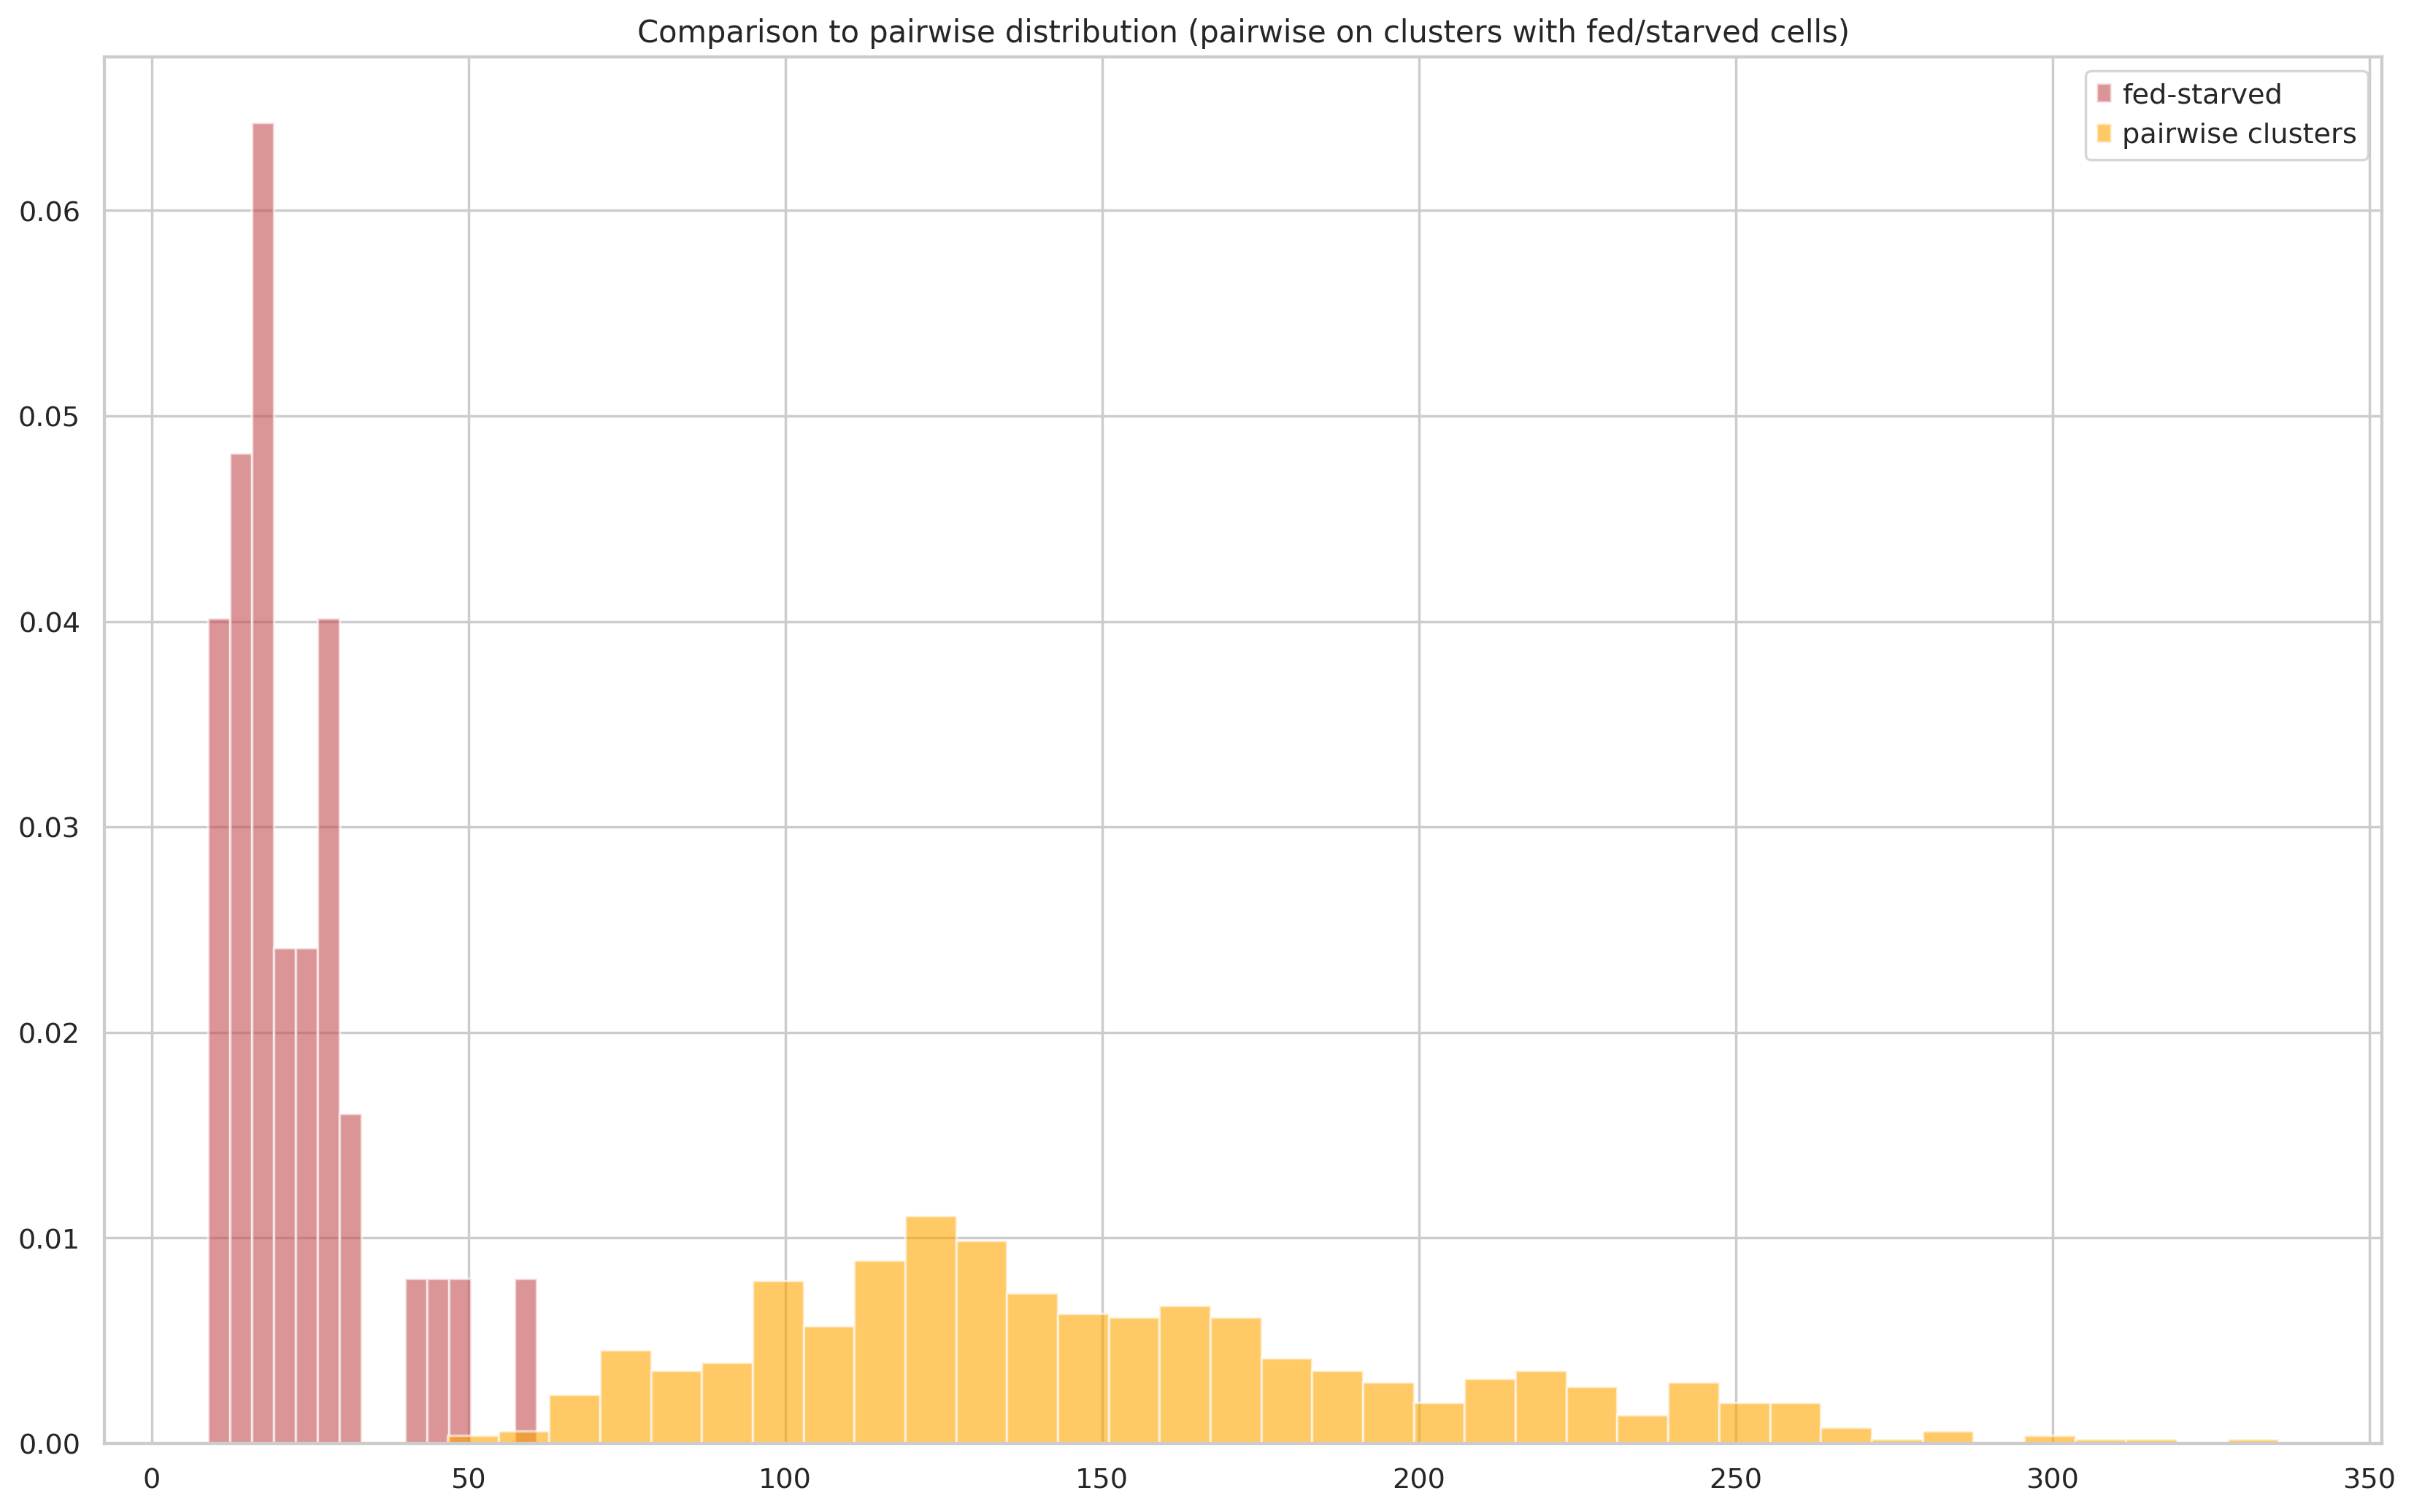

In [30]:
max(pairCentroid_dists.reshape((36*36,)))
reshape_noZero = [i for i in pairCentroid_dists.reshape((36*36,)) if i != 0]
print(np.min(reshape_noZero))

plt.figure(figsize=(16,10))
plt.hist(withinFS_Dists['fedStarv'],color='r',bins=15,alpha=0.6,label='fed-starved',density=True)

plt.hist(reshape_noZero, bins=36,color = 'orange',alpha=0.6,label='pairwise clusters',density=True)
plt.legend(loc='upper right')
plt.title('Comparison to pairwise distribution (pairwise on clusters with fed/starved cells)')
plt.show()

In [27]:
#Area where line between cell state/type is blurred seems to be only in digestive endodermal clusters 14,19 (strong metabolic responses to starvation)
outlier_clus = withinFS_Dists[withinFS_Dists.fedStarv> 46.69]['cluster']
outlier_clus


14    14
19    19
Name: cluster, dtype: int64

###**Organismal Distances, Fed/Starved + Stimulation**
Batch effect plots

In [17]:
#condition -- Stim, fed -- Fed/Starved data
overlap_combo

AnnData object with n_obs × n_vars = 32727 × 6756
    obs: 'batch', 'condition', 'fed', 'fed_neighbor_score', 'leiden', 'louvain', 'n_counts', 'n_countslog', 'orgID', 'starved', 'knn_clus', 'cell_origin'
    var: 'n_counts-0', 'n_counts-1'
    uns: 'cell_origin_colors', 'draw_graph', 'knn_clus_colors', 'knn_clus_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_draw_graph_fa', 'X_nca', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [66]:
#Use overlap_combo

#Go through each clustee
clus = np.unique(overlap_combo.obs['knn_clus'])

fed_data = overlap_combo[overlap_combo.obs['fed'] == 'True']
sw_data = overlap_combo[overlap_combo.obs['condition'] == 'SW']

fed_orgs = np.unique(fed_data.obs['orgID'])
sw_orgs = np.unique(sw_data.obs['orgID'])

pcs = 60

org_metadata = pd.DataFrame(columns =['orgID','cluster','condition']) #centroid = row mean for all cells in organism
num_points = (len(fed_orgs)+len(sw_orgs))*len(clus)

#Get centroid in PCA space in each cluster for each organism
org_centroids = np.zeros((num_points,pcs))

condition = []
cluster = []
orgID = []

count = 0
toRemove = []
for c in clus:
  #Get all cells in chosen condition
  fed_sub = fed_data[fed_data.obs['knn_clus'] == c]
  fed_pca_embed = fed_sub.obsm['X_pca'][:,0:pcs] #PCA matrix

  sw_sub = sw_data[sw_data.obs['knn_clus'] == c]
  sw_pca_embed = sw_sub.obsm['X_pca'][:,0:pcs] #PCA matrix

  #For each org, get centroid of cells (X_pca)
  for sw in sw_orgs:
    condition += ['SW']
    cluster += [c]
    orgID += [sw]

    #Get location of org cells
    org_pos = list(sw_sub.obs['orgID'] == sw)

    #Sum down rows of cells for each PC
    if len(sw_pca_embed[org_pos,]) == 0:
      toRemove += [count]

    org_centroids[count,:] = list(sw_pca_embed[org_pos,].mean(axis=0))

    count += 1

  for fed in fed_orgs:
    condition += ['Fed']
    cluster += [c]
    orgID += [fed]

    #Get location of org cells
    org_pos = list(fed_sub.obs['orgID'] == fed)
    #Sum down rows of cells for each PC
    if len(fed_pca_embed[org_pos,]) == 0:
      toRemove += [count]

    org_centroids[count,:] = list(fed_pca_embed[org_pos,].mean(axis=0))

    count += 1    

  #For each org, get centroid of cells (X_pca)

  #Average pairwise distance between org centroid

org_metadata['orgID'] = orgID
org_metadata['cluster'] = cluster
org_metadata['condition'] = condition




In [67]:
toRemove 

[181, 183]

In [68]:
org_metadata = org_metadata.drop(org_metadata.index[toRemove])
org_metadata.head()

org_centroids= np.delete(org_centroids, toRemove, 0)
org_centroids[0,:]

array([-2.5141046 , -1.83165169, -2.56139255, -0.30813822,  1.98264134,
       -1.87403417, -3.38868713, -0.13224465, -2.21397758, -1.29323554,
       -1.94140637, -1.32937133, -3.10828853,  0.80791473,  1.62436104,
       -0.25122994, -0.1887034 , -0.0583187 ,  0.72272348, -3.10565209,
        4.24892616,  0.37986624, -0.55612922,  0.59272265,  1.71611094,
        0.18304156, -0.49343768, -0.86163104,  0.33055994, -0.709203  ,
        0.56443644,  0.82765633, -0.53927851, -0.98591512, -0.33037487,
       -0.26226798, -0.02119251, -0.54339862, -0.05480121, -0.18422647,
        1.82246745,  0.5512197 , -0.12327559, -0.62353981,  0.45485938,
        0.32711661,  0.760185  ,  0.3137255 ,  0.22211218,  0.23228893,
        0.12949443,  0.16719288, -0.71052462, -0.33989388,  0.3274518 ,
       -0.18515548,  0.48728189,  0.23112439,  0.46149072, -0.40837356])

In [69]:
org_pairDists = pd.DataFrame(columns =['cluster','pair_fed','pair_sw','pair_mix'])
cluster = []
pair_fed = []
pair_sw = []
pair_mix = []

for c in clus:

  #Fed org centroids
  where_fed = (org_metadata.cluster == c) & (org_metadata.condition == 'Fed')
  fed_mat = org_centroids[where_fed,:]

  pair_fed_dist = pairwise_distances(fed_mat, metric = 'l1')
  pair_fed_mean = np.mean(pair_fed_dist)

  #SW org centroids
  where_sw = (org_metadata.cluster == c) & (org_metadata.condition == 'SW')
  sw_mat = org_centroids[where_sw,:]

  pair_sw_dist = pairwise_distances(sw_mat, metric = 'l1')
  pair_sw_mean = np.mean(pair_sw_dist)

  pair_mix_dist = pairwise_distances(fed_mat,sw_mat, metric = 'l1')
  pair_mix_mean = np.mean(pair_mix_dist)

  cluster += [c]
  pair_fed += [pair_fed_mean]
  pair_sw += [pair_sw_mean]
  pair_mix += [pair_mix_mean]

org_pairDists['cluster'] = cluster
org_pairDists['pair_fed'] = pair_fed
org_pairDists['pair_sw'] = pair_sw
org_pairDists['pair_mix'] = pair_mix

In [70]:
org_pairDists.head()

,cluster,pair_fed,pair_sw,pair_mix
0,0,6.435431,6.709091,23.432679
1,1,14.112677,34.774560,63.872450
2,2,8.279761,14.382547,53.206116
3,3,17.876802,26.969492,54.635241
4,4,15.024401,24.717512,34.451474


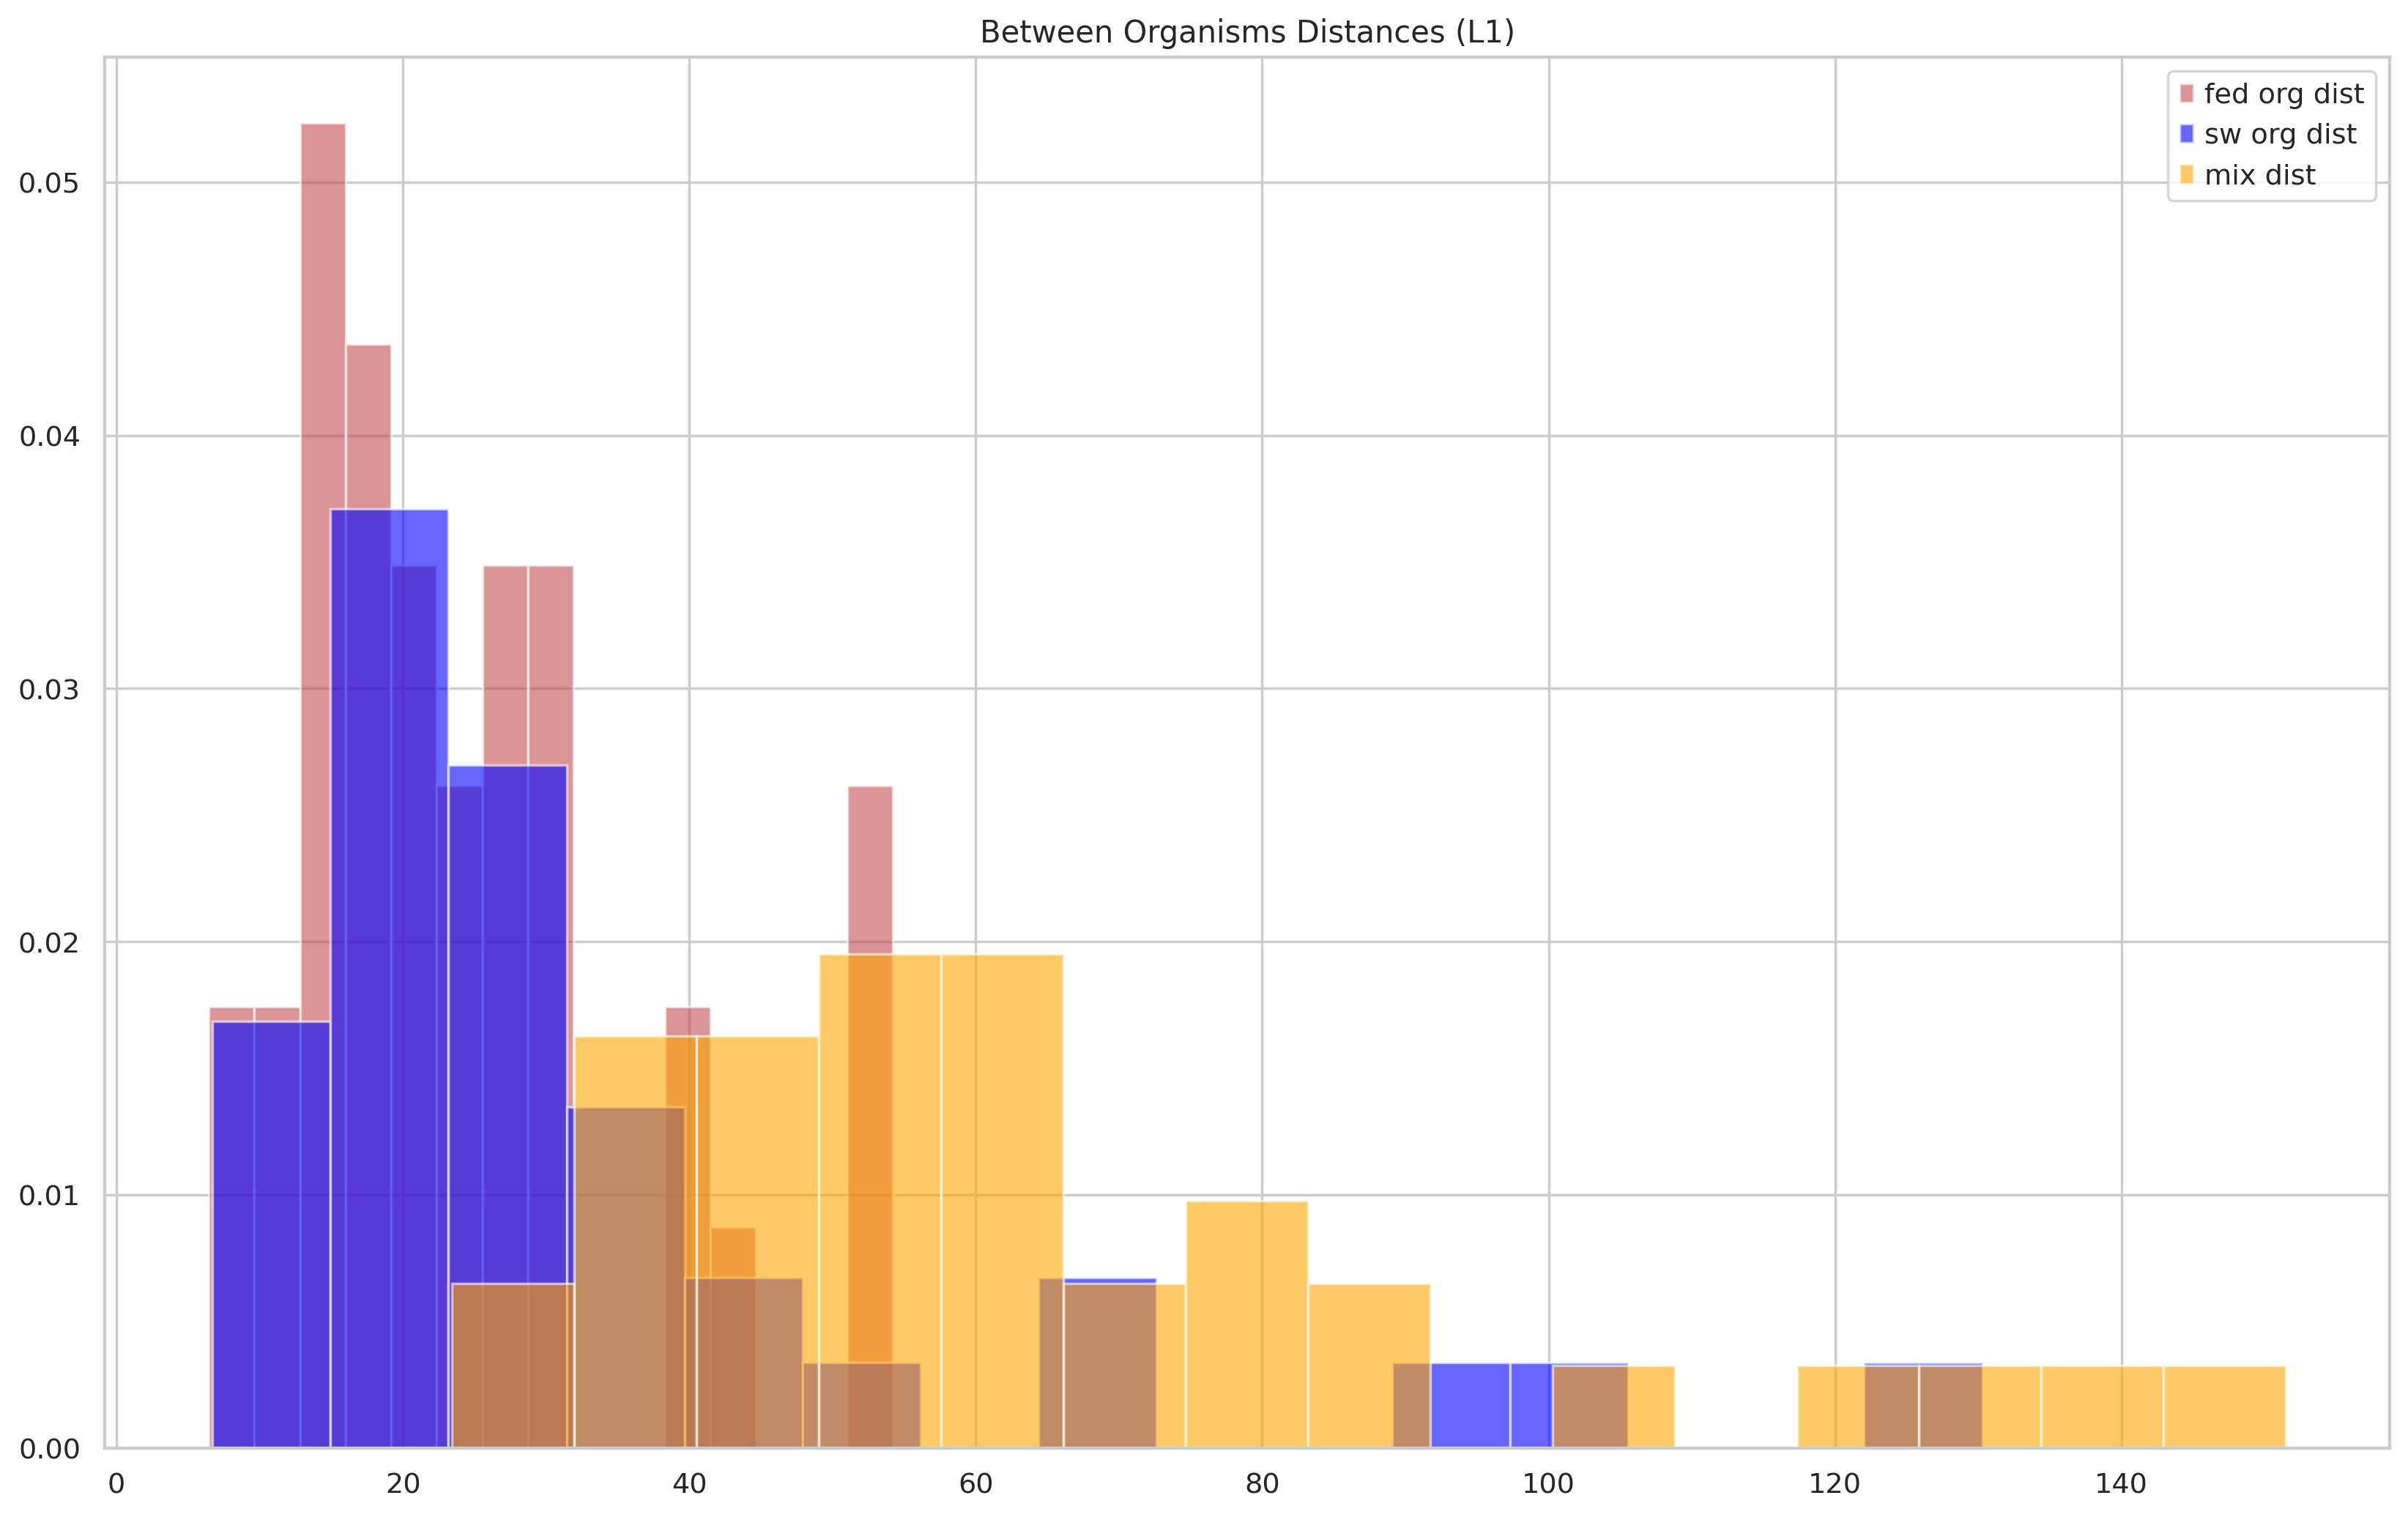

In [76]:
plt.figure(figsize=(16,10))
plt.hist(org_pairDists['pair_fed'],color='r',bins=15,alpha=0.6,label='fed org dist',density=True)
plt.hist(org_pairDists['pair_sw'],color='blue',bins=15,alpha=0.6,label='sw org dist',density=True)
plt.hist(org_pairDists['pair_mix'], bins=15,color = 'orange',alpha=0.6,label='mix dist',density=True)
plt.legend(loc='upper right')
plt.title('Between Organisms Distances (L1)')
plt.show()

###**Pearson Correlation Between F/S and Stim Cluster Markers**
Use KNN to map stim cells, assess mapping

In [ ]:
stim = overlap_combo 

In [109]:
sc.tl.rank_genes_groups(bus_fs_combo,groupby='cellRanger_louvain',n_genes=100,method='wilcoxon')

bus_combo_noZero.obs['cellRanger_louvain'] = 
sc.pp.highly_variable_genes(overlap_combo,)
overlap_combo

AnnData object with n_obs × n_vars = 32727 × 6756
    obs: 'batch', 'condition', 'fed', 'fed_neighbor_score', 'leiden', 'louvain', 'n_counts', 'n_countslog', 'orgID', 'starved', 'knn_clus', 'cell_origin'
    var: 'n_counts-0', 'n_counts-1'
    uns: 'cell_origin_colors', 'draw_graph', 'knn_clus_colors', 'knn_clus_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_groups'
    obsm: 'X_draw_graph_fa', 'X_nca', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [151]:
from scipy.stats import pearsonr
#sub = overlap_combo[overlap_combo.obs['knn_clus'] == 26]
genes = []

#genes = list(overlap_combo.uns['rank_genes_groups']['names'][c])
#sub = overlap_combo[:,genes]

fs = overlap_combo[overlap_combo.obs['cell_origin'] == 'FS']
stim = overlap_combo[overlap_combo.obs['cell_origin'] == 'Stim']

n= 100
sc.tl.rank_genes_groups(fs,groupby='knn_clus',n_genes=n,method='wilcoxon')
sc.tl.rank_genes_groups(stim,groupby='knn_clus',n_genes=n,method='wilcoxon')

#plt.scatter(np.sum(fs.raw.toarray(),axis=0),np.sum(stim.raw.toarray(),axis=0))

#plt.scatter(fs.X,stim.X)


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [152]:
#n=50
for c in clus:
  len1 = len(fs[fs.obs['knn_clus']==c].obs_names)
  len2 = len(stim[stim.obs['knn_clus']==c].obs_names)
  print('clus: '+str(c)+' - '
      + str(len(set(fs.uns['rank_genes_groups']['names'][str(c)]).intersection(stim.uns['rank_genes_groups']['names'][str(c)]))/n) 
  + ': '+str(len1/len2))
  
  print()

clus: 0 - 0.45: 0.9845559845559846

clus: 1 - 0.56: 3.9125

clus: 2 - 0.71: 0.3454404945904173

clus: 3 - 0.59: 0.9413067552602437

clus: 4 - 0.7: 0.9269282814614344

clus: 5 - 0.66: 1.4901960784313726

clus: 6 - 0.55: 0.6837606837606838

clus: 7 - 0.64: 0.8112965340179717

clus: 8 - 0.67: 1.1640316205533596

clus: 9 - 0.53: 0.7931570762052877

clus: 10 - 0.62: 1.4477611940298507

clus: 11 - 0.81: 0.4733201581027668

clus: 12 - 0.69: 0.4937853107344633

clus: 13 - 0.72: 1.1385135135135136

clus: 14 - 0.67: 0.8025

clus: 15 - 0.73: 0.42756680731364277

clus: 16 - 0.73: 0.5549242424242424

clus: 17 - 0.82: 0.42164781906300486

clus: 18 - 0.68: 0.5272727272727272

clus: 19 - 0.64: 0.6207729468599034

clus: 20 - 0.42: 8.096774193548388

clus: 21 - 0.63: 0.8025889967637541

clus: 22 - 0.91: 0.3131868131868132

clus: 23 - 0.79: 0.35266457680250785

clus: 24 - 0.6: 0.4434589800443459

clus: 25 - 0.82: 0.5431654676258992

clus: 26 - 0.48: 2.642857142857143

clus: 27 - 0.95: 0.3415841584158416


In [ ]:
from scipy.stats import pearsonr
#sub = overlap_combo[overlap_combo.obs['knn_clus'] == 26]
genes = []

for c in clus:
  genes += list(overlap_combo.uns['rank_genes_groups']['names'][str(c)])
#sub = overlap_combo[:,genes]

fs = overlap_combo[overlap_combo.obs['cell_origin'] == 'FS']
stim = overlap_combo[overlap_combo.obs['cell_origin'] == 'Stim']

n= 20
sc.tl.rank_genes_groups(fs,groupby='knn_clus',n_genes=n,method='wilcoxon')
sc.tl.rank_genes_groups(stim,groupby='knn_clus',n_genes=n,method='wilcoxon')

#plt.scatter(np.sum(fs.raw.toarray(),axis=0),np.sum(stim.raw.toarray(),axis=0))

#plt.scatter(fs.X,stim.X)


In [12]:
# allCells_Dists = getCentroidDists(overlap_combo,pcs=60)
# #controlCells_Dists = getCentroidDists(overlap_combo_fed_sw,pcs=60)

In [ ]:
# plt.figure(figsize=(16,10))
# plt.scatter(x='cluster', y='fedStarv', data=allCells_Dists,color='red',label='fed-starved')
# plt.scatter(x='cluster', y='fsStim', data=allCells_Dists,color='blue',label='starved-stim')
# #plt.scatter(x='cluster', y='fsStim', data=controlCells_Dists,color='black',label='fed-sw control',s=100)
# plt.legend()
# plt.xticks(np.arange(min(allCells_Dists['cluster']), max(allCells_Dists['cluster'])+1, 1))
# plt.show()

In [52]:
# #Compare to pairwise distances between cell atlas clusters
# fs_celltypes = overlap_combo[overlap_combo.obs['cell_origin'] == 'FS']

# centroids = getClusCentroids(fs_celltypes,pcs=60)
# #centroids_arr = centroids['centroid'].to_numpy()
# pairCentroid_dists = pairwise_distances(centroids, metric = 'l1')
# pairCentroid_dists.shape
# print(np.mean(pairCentroid_dists))


144.73460022468623


In [1]:
# max(pairCentroid_dists.reshape((36*36,)))
# reshape_noZero = [i for i in pairCentroid_dists.reshape((36*36,)) if i != 0]
# print(np.min(reshape_noZero))

# plt.figure(figsize=(16,10))
# plt.hist(allCells_Dists['fedStarv'],color='r',bins=15,alpha=0.6,label='fed-starved',density=True)
# plt.hist(allCells_Dists['fsStim'],color='blue',bins=15,alpha=0.6,label='fs-stim',density=True)
# plt.hist(reshape_noZero, bins=15,color = 'orange',alpha=0.6,label='pairwise clusters',density=True)
# plt.legend(loc='upper right')
# plt.title('Comparison to pairwise distribution (pairwise on clusters with fed/starved+stim cells)')
# plt.show()

In [54]:
# np.min(reshape_noZero)

41.17746266908944

In [2]:
# outlier_clus = allCells_Dists[allCells_Dists['fsStim']> 41]['cluster']
# len(outlier_clus)

In [3]:
# log2fc_thr = 1
# padj_thr = 0.01
# outlier_dist = 41

# outlier_clus = allCells_Dists[allCells_Dists['fsStim']> outlier_dist]['cluster']

# subCluster_Genes = {}

# for c in outlier_clus:
#   score = 0 
#   clus = overlap_combo[overlap_combo.obs['knn_clus'].isin([c])]
#   sc.tl.rank_genes_groups(clus,groupby='cell_origin',method='wilcoxon')

#   #Filter results by thresholds
#   pvals = clus.uns['rank_genes_groups']['pvals_adj']['Stim']
#   names = clus.uns['rank_genes_groups']['names']['Stim']

#   fc_filter = clus.uns['rank_genes_groups']['logfoldchanges']['Stim'] > log2fc_thr
#   pvals_filt = pvals[fc_filter]
#   names = names[fc_filter]

#   #Filter by p-val cutoff
#   pvals_filt_new = pvals_filt[pvals_filt < padj_thr]

  
#   names = names[pvals_filt < padj_thr]

#   if len(pvals_filt_new) != 0:
#     score = -np.log10(np.sum(pvals_filt_new))
#     #print(c)
#     print(str(c)+':'+str(len(names)))
#     subCluster_Genes[c] = names
#     #print(score) 
#     #print(len(clus.obs_names))

# #subCluster_Genes

In [ ]:
#Optimize for pseudotime and cell type labels in embedding